# Cell Nuclei Separation using Marker-Controlled Watershed

**Task:** Separate touching nuclei  
**Method:** Marker-controlled watershed  
**Dataset:** Data Science Bowl 2018 (merged masks)  
**Comparison:** Watershed with vs without markers  
**Learning Outcome:** Control over-segmentation using markers

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, filters, morphology, segmentation, measure, feature
from skimage.color import rgb2gray
from scipy import ndimage as ndi

In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download(
    "mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask"
)

BASE_DIR = os.path.join(dataset_path, "data science bowl 2018", "train")

print("Base directory:", BASE_DIR)

100%|██████████| 84.4M/84.4M [00:02<00:00, 31.6MB/s]

Extracting files...


Base directory: /root/.cache/kagglehub/datasets/mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask/versions/1/data science bowl 2018/train


In [4]:
import os
from skimage import io
import numpy as np

# Automatically locate a sample folder that contains images + masks
sample_path = None

for root, dirs, files in os.walk(dataset_path):
    if "images" in dirs and "masks" in dirs:
        sample_path = root
        break

if sample_path is None:
    raise RuntimeError("Could not find images/masks folder automatically.")

print("Using sample folder:", sample_path)

IMAGE_DIR = os.path.join(sample_path, "images")
MASK_DIR = os.path.join(sample_path, "masks")

# Load image
image_file = os.listdir(IMAGE_DIR)[0]
image_path = os.path.join(IMAGE_DIR, image_file)
image = io.imread(image_path)

# Merge instance masks into single mask
mask = np.zeros(image.shape[:2], dtype=np.uint8)

for m in os.listdir(MASK_DIR):
    m_img = io.imread(os.path.join(MASK_DIR, m))
    mask = np.maximum(mask, m_img)

print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

Using sample folder: /root/.cache/kagglehub/datasets/mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask/versions/1/data science bowl 2018/stage1_train 2/a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4
Image shape: (256, 320, 4)
Mask shape: (256, 320)


In [5]:
# Convert RGBA/RGB → Grayscale safely
if image.ndim == 3:
    if image.shape[2] == 4:
        image = image[:, :, :3]
    image_gray = rgb2gray(image)
else:
    image_gray = image

# Normalize
image_gray = (image_gray - image_gray.min()) / (image_gray.max() - image_gray.min())

mask_bin = (mask > 0).astype(np.uint8)

In [6]:
gradient = filters.sobel(image_gray)
labels_no_markers = segmentation.watershed(gradient)

In [7]:
# Distance transform
distance = ndi.distance_transform_edt(mask_bin)

# Local maxima → markers
local_max = feature.peak_local_max(
    distance,
    min_distance=15,
    labels=mask_bin
)

markers = np.zeros_like(distance, dtype=int)
for i, coord in enumerate(local_max, start=1):
    markers[coord[0], coord[1]] = i

markers = ndi.label(markers)[0]

# Marker-controlled watershed
labels_markers = segmentation.watershed(
    -distance,
    markers,
    mask=mask_bin
)

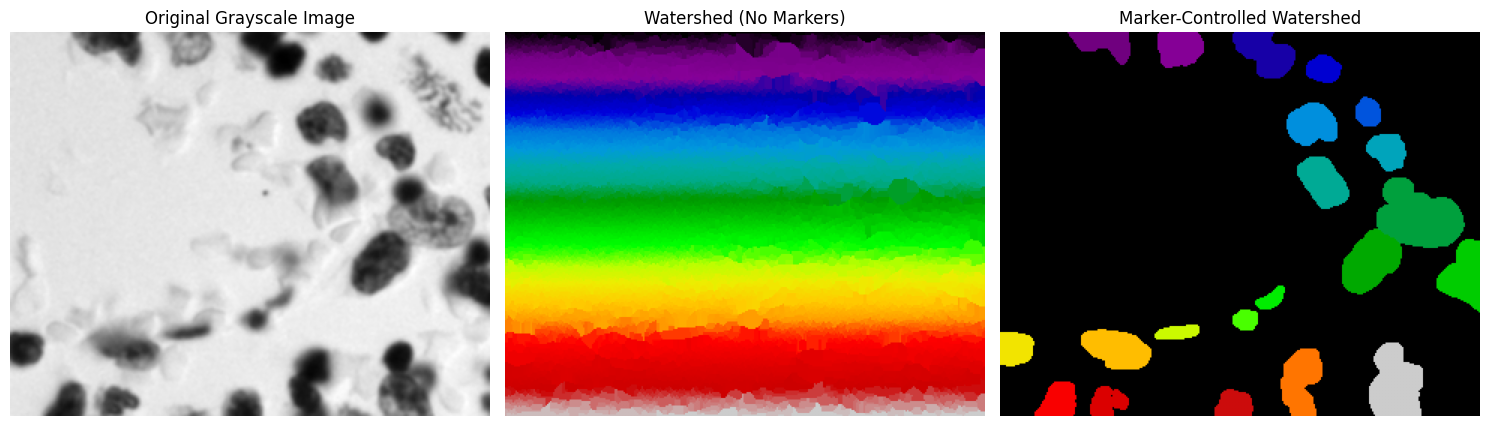

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_gray, cmap="gray")
plt.title("Original Grayscale Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(labels_no_markers, cmap="nipy_spectral")
plt.title("Watershed (No Markers)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(labels_markers, cmap="nipy_spectral")
plt.title("Marker-Controlled Watershed")
plt.axis("off")

plt.tight_layout()
plt.show()

## Conclusion

Marker-controlled watershed successfully separates individual nuclei by guiding region growth using predefined markers derived from the distance transform. This significantly reduces over-segmentation and improves instance separation.

The experiment highlights the importance of marker initialization in watershed-based segmentation for biomedical images, particularly when dealing with touching or overlapping nuclei.